# Portfolio Risk and Performance of Asset Allocation Weighting Schemes
by Chee-Foong on 13 Nov 2020

## Summary
Purpose of this analysis is to study the risk and performance of different weighting schemes when come to asset allocation.  

Two most common weighting schemes in **Modern Portfolio Theory** is the ***Maximum Sharpe Ratio (MSR)*** and the ***Global Minimum Volatility (GMV)*** portfolios.  These 2 portfolios lie on the efficient frontier.  

Togther with two other weighting schemes, namely the ***Equally Weighted Portfolio (EW)*** and the ***Equal Risk Contribution Portfolio (ERC)***, we shall backtest and see how the respective portfolio performs over the same period.

## Asset Allocation Weighting Schemes
1. MSR: Maximum Sharpe Ratio
2. GMV: Global Minimum Volatility
3. EW: Equally Weighted
4. ERC: Equal Risk Contribution (Risk Parity)

## Data
Price data are downloaded from yahoo finance.  Monthly returns are calculated and then used to estimate the asset expected returns and covariance matrix.

## Assets
Three asset classes are selected for this analysis:
- Equity: iShares Core U.S. Aggregate Bond
- Fixed Income: SPDR S&P 500
- Commodity: SPDR Gold Trust

Risk Free Rate: CBOE Interest Rate 10 Year T Note

## Backtesting 
Portfolio is rebalanced at the end of each month using past 36 months of returns.  The portfolio returns for the forward months are calculated and cumulative returns plotted for performance comparison.

----

## Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

import sys  
sys.path.append('../src') 
from edge_risk_kit import *

import edge_risk_kit as erk

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

DATA_FOLDER = '../data/'

## Importing Data from Yahoo Finance
Tickers:  
- AGG - iShares Core U.S. Aggregate Bond
- SPY - SPDR S&P 500
- GLD - SPDR Gold Trust
- ^TNX - CBOE Interest Rate 10 Year T Note (Risk Free Rate)

Date Range:  
1 Jan 2012 to 31 Dec 2020

In [3]:
tickers = ['AGG','SPY','GLD','^TNX']

start_date = '2012-01-01'
end_date = '2020-12-31'

In [4]:
import yfinance as yf

tickerlist = {}
for ticker in tickers:
    tickerlist[ticker] = yf.Ticker(ticker).info['shortName']
    
data = yf.download(tickers, start=start_date, end=end_date)

[*********************100%***********************]  4 of 4 completed


In [5]:
prices = data['Adj Close'][tickers].dropna()

In [6]:
tickerlist

{'AGG': 'iShares Core U.S. Aggregate Bon',
 'SPY': 'SPDR S&P 500',
 'GLD': 'SPDR Gold Trust',
 '^TNX': 'CBOE Interest Rate 10 Year T No'}

In [7]:
namelist = tickerlist
namelist['AGG'] = 'iShares Core U.S. Aggregate Bond'
namelist['SPY'] = 'SPDR S&P 500'
namelist['GLD'] = 'SPDR Gold Trust'

In [8]:
# prices.tail()

## Risk Free Rate - 10 Year Treasury Yield

In [9]:
rfr = prices['^TNX']/100
print('Risk Free Rate: {:.3f}%'.format(rfr[-1]*100))

Risk Free Rate: 0.913%


In [10]:
rfr_monthly = rfr.resample('M').fillna('ffill')
rfr_monthly.index = rfr_monthly.index.to_period('M')

## Monthly Returns

In [11]:
to_drop = ['^TNX']
px = prices.drop(to_drop, axis=1)
print('Number of funds: {}'.format(len(px.columns)))
px.columns = px.columns.map(namelist)

Number of funds: 3


In [12]:
px_monthly = px.resample('M').fillna('ffill')
px_monthly.index = px_monthly.index.to_period('M')

rets_monthly = px_monthly.pct_change().dropna()

----

## Summary Analysis 
Based on data from 2015 - 2020

In [13]:
rfr_period = rfr_monthly.loc['2015':]
rets_period = rets_monthly.loc['2015':]

### Cumulative Wealth Ratio

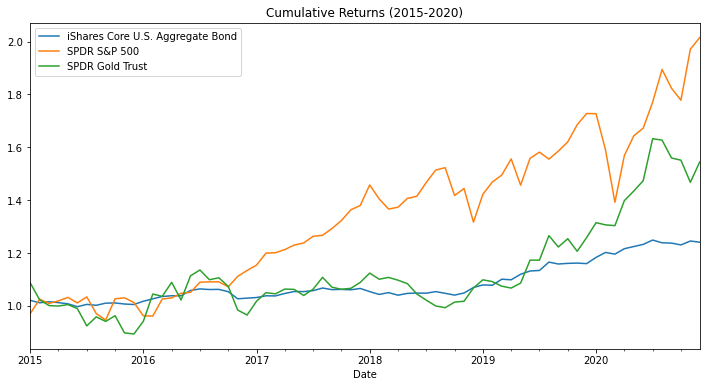

In [14]:
wr_mthly_cum = (rets_period+1).cumprod()
wr_mthly_cum.plot(title='Cumulative Returns (2015-2020)', figsize=(12,6))
plt.show()

### Summary statistics of returns

In [15]:
erk.summary_stats(rets_period, riskfree_rate=rfr_period[-1]).sort_values('Sharpe Ratio', ascending=False) \
            .style.bar(color=['pink', 'lightgreen'], align='zero')

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
iShares Core U.S. Aggregate Bond,0.036603,0.032593,0.171097,3.476101,0.011775,0.014440,0.835915,-0.035201
SPDR S&P 500,0.123946,0.148795,-0.333003,4.257439,0.062330,0.090297,0.765205,-0.194477
SPDR Gold Trust,0.075216,0.143257,0.371955,3.001185,0.056206,0.069670,0.457442,-0.178129


### Plotting the Efficient Frontier
- Yellow: Equally Weighted Portfolio
- Green: Maximum Sharpe Ratio Portfolio
- Blue: Global Minimum Volatility Portfolio
- Red: Equal Risk Contribution Portfolio

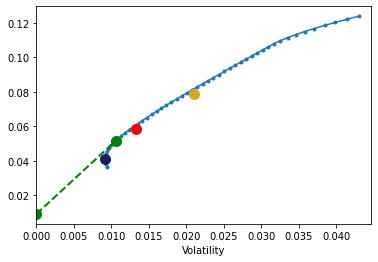

In [16]:
er = erk.annualize_rets(rets_period, periods_per_year=12)
cov = rets_period.cov()
erk.plot_ef(50, er, cov, riskfree_rate = rfr_period[-1], show_cml=True, show_ew=True, show_gmv=True, show_erc=True)
plt.show()

#### Equally Weighted Portfolio

In [17]:
n = er.shape[0]
w_eq = np.repeat(1/n, n)
w_eq = erk.weight_ew(rets_period)
pd.DataFrame((w_eq*100).round(3), 
             index=er.index, columns=['weights']).sort_values('weights', ascending=False).head()

,weights
iShares Core U.S. Aggregate Bond,33.333
SPDR S&P 500,33.333
SPDR Gold Trust,33.333


In [18]:
print('Portfolio Return: {:.2f}%'.format(erk.portfolio_return(w_eq, er)*100))
print('Portfolio Volatility: {:.2f}%'.format(erk.portfolio_vol(w_eq, cov)*100))

Portfolio Return: 7.86%
Portfolio Volatility: 2.10%


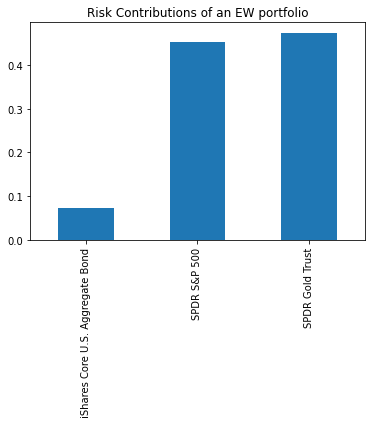

In [19]:
erk.risk_contribution(w_eq, cov).plot.bar(title="Risk Contributions of an EW portfolio")
plt.show()

#### Maximum Sharpe Ratio Portfolio

In [20]:
w_msr = erk.msr(rfr_period[-1], er, cov)
pd.DataFrame((w_msr*100).round(3), 
             index=er.index, columns=['weights']).sort_values('weights', ascending=False).head()

,weights
iShares Core U.S. Aggregate Bond,82.735
SPDR S&P 500,16.865
SPDR Gold Trust,0.400


In [21]:
print('Portfolio Return: {:.2f}%'.format(erk.portfolio_return(w_msr, er)*100))
print('Portfolio Volatility: {:.2f}%'.format(erk.portfolio_vol(w_msr, cov)*100))

Portfolio Return: 5.15%
Portfolio Volatility: 1.05%


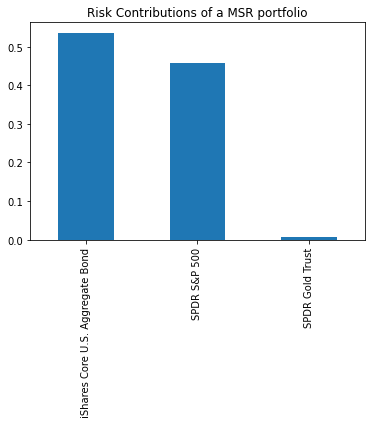

In [22]:
erk.risk_contribution(w_msr, cov).plot.bar(title="Risk Contributions of a MSR portfolio")
plt.show()

#### Global Minimum Volatility Portfolio

In [23]:
w_gmv = erk.gmv(cov)
pd.DataFrame((w_gmv*100).round(3), 
             index=er.index, columns=['weights']).sort_values('weights', ascending=False).head()

,weights
iShares Core U.S. Aggregate Bond,94.876
SPDR S&P 500,5.124
SPDR Gold Trust,0.000


In [24]:
print('Portfolio Return: {:.2f}%'.format(erk.portfolio_return(w_gmv, er)*100))
print('Portfolio Volatility: {:.2f}%'.format(erk.portfolio_vol(w_gmv, cov)*100))

Portfolio Return: 4.11%
Portfolio Volatility: 0.91%


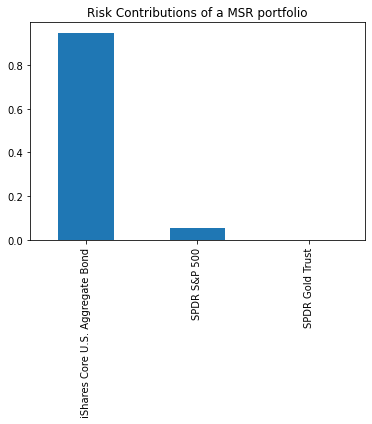

In [25]:
erk.risk_contribution(w_gmv, cov).plot.bar(title="Risk Contributions of a MSR portfolio")
plt.show()

#### Equal Risk Contribution (Risk Parity) Portfolio

In [26]:
w_erc = erk.equal_risk_contributions(cov)
pd.DataFrame((w_erc*100).round(3), 
             index=er.index, columns=['weights']).sort_values('weights', ascending=False).head()

,weights
iShares Core U.S. Aggregate Bond,66.708
SPDR S&P 500,18.214
SPDR Gold Trust,15.077


In [27]:
print('Portfolio Return: {:.2f}%'.format(erk.portfolio_return(w_erc, er)*100))
print('Portfolio Volatility: {:.2f}%'.format(erk.portfolio_vol(w_erc, cov)*100))

Portfolio Return: 5.83%
Portfolio Volatility: 1.33%


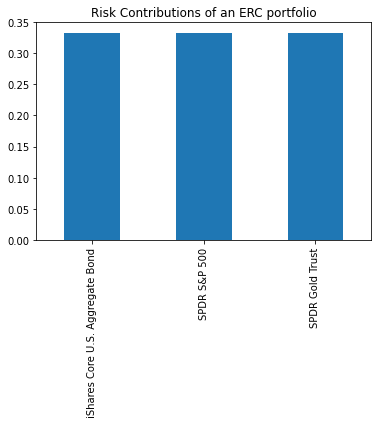

In [28]:
risk_contribution(w_erc, cov).plot.bar(title="Risk Contributions of an ERC portfolio")
plt.show()

----
## Backtesting

### Returns from 2015 to 2020

In [29]:
rets_period = rets_monthly['2015':]
rfr_period = rfr_monthly['2015':]

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.108645,0.084036,0.453170,3.479433,0.027026,0.035416,1.174381,-0.066323
GMV,0.056195,0.036396,-0.009947,2.587554,0.012536,0.015876,1.282423,-0.018847
ERC,0.081649,0.055251,0.351411,3.290336,0.017484,0.023377,1.301641,-0.035580
MSR,0.057494,0.102485,-0.847089,3.921286,0.048971,0.067098,0.467961,-0.113897


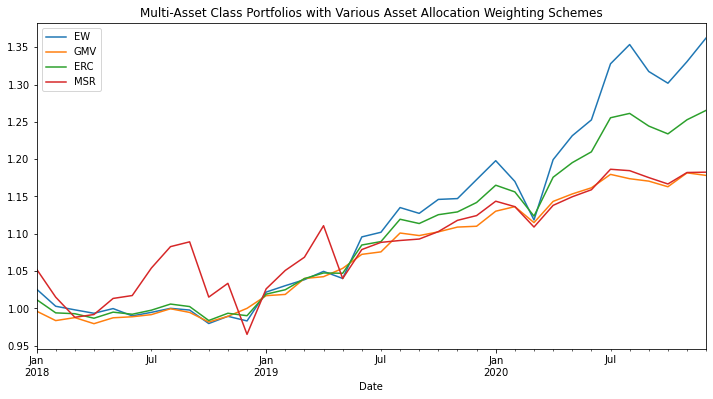

In [30]:
ewr = erk.backtest_ws(rets_period, estimation_window=36, weighting=erk.weight_ew)
gmv = erk.backtest_ws(rets_period, estimation_window=36, weighting=erk.weight_gmv, cov_estimator=erk.sample_cov)
erc = erk.backtest_ws(rets_period, estimation_window=36, weighting=erk.weight_erc, cov_estimator=erk.sample_cov)
msr = erk.backtest_ws(rets_period, estimation_window=36, weighting=erk.weight_msr, cov_estimator=erk.sample_cov,
                      periods_per_year=12, rfr_series=rfr_period)

btr = pd.DataFrame({"EW": ewr, "GMV": gmv, "ERC": erc, "MSR": msr})
btr.dropna(inplace=True)
(1+btr).cumprod().plot(figsize=(12,6), title="Multi-Asset Class Portfolios with Various Asset Allocation Weighting Schemes")
erk.summary_stats(btr.dropna(), riskfree_rate=rfr_period[-1])

### Returns from 2012 to 2020

In [31]:
rets_period = rets_monthly
rfr_period = rfr_monthly

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.079485,0.072850,0.548045,3.701082,0.024071,0.029546,0.957740,-0.066323
GMV,0.040758,0.032011,-0.077379,3.290844,0.011863,0.016399,0.979818,-0.031176
ERC,0.061898,0.047251,0.419859,3.694446,0.015318,0.020726,1.107479,-0.035580
MSR,0.058627,0.093389,-0.491363,4.823953,0.041544,0.064729,0.525580,-0.113897


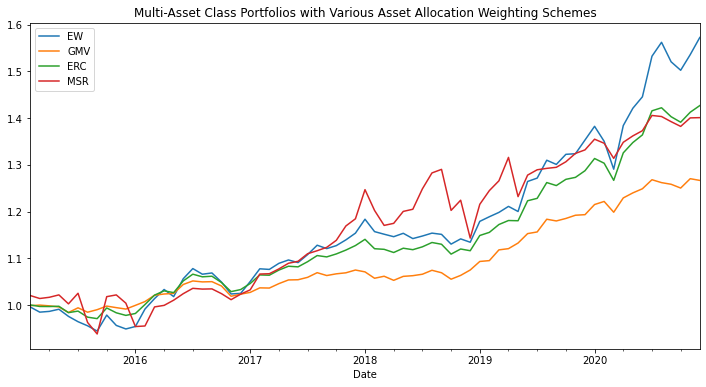

In [32]:
ewr = erk.backtest_ws(rets_period, estimation_window=36, weighting=erk.weight_ew)
gmv = erk.backtest_ws(rets_period, estimation_window=36, weighting=erk.weight_gmv, cov_estimator=erk.sample_cov)
erc = erk.backtest_ws(rets_period, estimation_window=36, weighting=erk.weight_erc, cov_estimator=erk.sample_cov)
msr = erk.backtest_ws(rets_period, estimation_window=36, weighting=erk.weight_msr, cov_estimator=erk.sample_cov,
                      periods_per_year=12, rfr_series=rfr_period)

btr = pd.DataFrame({"EW": ewr, "GMV": gmv, "ERC": erc, "MSR": msr})
btr.dropna(inplace=True)
(1+btr).cumprod().plot(figsize=(12,6), title="Multi-Asset Class Portfolios with Various Asset Allocation Weighting Schemes")
erk.summary_stats(btr.dropna(), riskfree_rate=rfr_period[-1])

## Conclusion

In terms of Sharpe Ratio, the EW and ERC portfolios performs much better than MSR and GMV portfolios.  The ERC and GMV portfolios have relative lower maximum drawdown as compared to EW.  Reason being these 2 portfolios, rebalance the portfolios with covariance being the parameter.  GMV reallocates the weights based on minimum portfolio volatility.  ERC reallocates the weights based on risk contribution; lesser weightage to assets with higher risk contribution and vice versa.